In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import median_absolute_error
import warnings
warnings.filterwarnings('ignore')

### Background

This data is queried from the clipper.sfofaretransaction table on the data lake. Different data sources across the agency will have different numbers.  This is to demonstrate that ridership can be predicted, but the counts may not match up with official accounts from crystal reports.  This data is for years avaliable in the lake database and for all operators combined.

	yesterday_swipes = The number of clipper rides on BART the pervious day
    
    year_ago_swipes = The number of clipper rides on BART on that day last year
    
    weekday_avg_month_prior =  The average daily weekday ridership for the pervious month
    
    weekdend_avg_month_prior =  The average daily weekend ridership for the pervious month

In [2]:
rides = pd.read_csv("all_ops_all_years_with_features.csv")
# there will be nan's for dates in 2013 where we don't have prior months data
rides_1418 = rides.dropna()

### EDA

In [5]:
# daily average accross all years
np.mean(rides.swipes), np.mean(rides_1418.swipes)

(633564.0856748043, 652994.2081949059)

In [6]:
# weekday average accross all years
np.mean(rides[rides.weekend_flag==False].swipes), np.mean(rides_1418[rides_1418.weekend_flag==False].swipes)

(730119.3268858801, 754561.5868217055)

In [7]:
# weekend average accross all years
np.mean(rides[rides.weekend_flag==True].swipes), np.mean(rides_1418[rides_1418.weekend_flag==True].swipes)

(392020.2483870968, 399075.761627907)

In [8]:
# average difference in swipes from one day to another accross all years
np.mean(rides.swipes - rides.yesterday_swipes), np.mean(rides_1418.swipes - rides_1418.yesterday_swipes)
# This makes sense sense not all the data came in the beginning

(165.72718894009216, 11.39202657807309)

In [9]:
# average difference in swipes from one day to another 2018
np.mean(rides[rides.year==2018].swipes - rides[rides.year==2018].yesterday_swipes), np.mean(rides_1418[rides_1418.year==2018].swipes - rides_1418[rides_1418.year==2018].yesterday_swipes)


(289.45753424657534, 289.45753424657534)

In [10]:
# average difference in swipes from one day to another 2017

np.mean(rides_1418[rides_1418.year==2017].swipes - rides_1418[rides_1418.year==2017].yesterday_swipes)

-237.27945205479452

In [11]:
# average difference in swipes from one day to another 2016

np.mean(rides_1418[rides_1418.year==2016].swipes - rides_1418[rides_1418.year==2016].yesterday_swipes)

-453.827868852459

In [12]:
# average difference in swipes from one day to another 2015

np.mean(rides_1418[rides_1418.year==2015].swipes - rides_1418[rides_1418.year==2015].yesterday_swipes)

-25.734246575342464

In [13]:
# average difference in swipes from one day to another 2014

np.mean(rides_1418[rides_1418.year==2014].swipes - rides_1418[rides_1418.year==2014].yesterday_swipes)

513.1101449275362

In [14]:
# average difference in swipes from the swipes on that day last year  accross all years (same because 2013 doesn't have this data)
np.mean(rides.swipes - rides.year_ago_swipes), np.mean(rides_1418.swipes - rides_1418.year_ago_swipes)

(29773.837763012183, 29773.837763012183)

In [15]:
# average difference in swipes from one day to another on weekdays accross all years
np.mean(rides[rides.weekend_flag==False].swipes - rides[rides.weekend_flag==False].yesterday_swipes), np.mean(rides_1418[rides_1418.weekend_flag==False].swipes - rides_1418[rides_1418.weekend_flag==False].yesterday_swipes)

(87134.04451612903, 90607.73178294573)

In [16]:
# average difference in swipes from one day to another on weekends  accross all years
np.mean(rides[rides.weekend_flag==True].swipes - rides[rides.weekend_flag==True].yesterday_swipes), np.mean(rides_1418[rides_1418.weekend_flag==True].swipes - rides_1418[rides_1418.weekend_flag==True].yesterday_swipes)

(-217255.06612903226, -226479.4573643411)

# RF Model with No Holidays and No Weather Data

In [20]:
rides_sorted = rides_1418.sort_values('date')
rides_sorted.head()

,date,year,month,day,month_year,dow,year.1,weekend_flag,yesterday,year_ago,...,season,swipes,y_date,yesterday_swipes,ly_date,year_ago_swipes,mwd_month_year,weekday_avg_month_prior,mwe_month_year,weekend_avg_month_prior
970,2014-01-21,2014,1,21,12014,2,2014,False,2014-01-20,2013-01-21,...,1,610287,2014-01-20,339254.0,2013-01-21,200.0,122013.0,584184.0,122013.0,358631.0
1342,2014-01-22,2014,1,22,12014,3,2014,False,2014-01-21,2013-01-22,...,1,750258,2014-01-21,610287.0,2013-01-22,731.0,122013.0,584184.0,122013.0,358631.0
2161,2014-01-23,2014,1,23,12014,4,2014,False,2014-01-22,2013-01-23,...,1,744432,2014-01-22,750258.0,2013-01-23,600.0,122013.0,584184.0,122013.0,358631.0
1187,2014-01-24,2014,1,24,12014,5,2014,False,2014-01-23,2013-01-24,...,1,731204,2014-01-23,744432.0,2013-01-24,738.0,122013.0,584184.0,122013.0,358631.0
1184,2014-01-25,2014,1,25,12014,6,2014,True,2014-01-24,2013-01-25,...,1,493683,2014-01-24,731204.0,2013-01-25,1580.0,122013.0,584184.0,122013.0,358631.0


In [41]:
split = int(.8*len(rides_sorted))

train_data = rides_sorted.iloc[0:split, :]
test_data = rides_sorted.iloc[split:, :]

features = ['month', 'day', 'dow', 'year', 'season', 'weekend_flag', 'yesterday_swipes', 'year_ago_swipes', 'weekday_avg_month_prior', 'weekend_avg_month_prior']

X = rides_sorted[features]
y = rides_sorted['swipes']
X_train = train_data[features]
X_test = test_data[features] 
y_train = train_data['swipes']
y_test = test_data['swipes']



rides_rf = RandomForestRegressor().fit(X_train, y_train)

rides_rf.score(X_test, y_test) # coefficient of determination R^2 of the prediction.
# depending on the random split this will vary

0.9082102935433509

In [42]:
# Use the forest's predict method on the test data
predictions = rides_rf.predict(X_test)
# Calculate the absolute errors
abs_errors = abs(predictions - y_test)
sq_errors = (predictions - y_test)**2
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(abs_errors), 4))
print('RMSE :', round(np.sqrt(np.mean(sq_errors)), 4))

Mean Absolute Error: 42308.308
RMSE : 66983.9177


In [43]:
from sklearn.metrics import median_absolute_error
median_absolute_error(y_test, predictions)

24154.600000000035

In [44]:
from sklearn.model_selection import cross_val_score

scores_dtr = cross_val_score(rides_rf, X, y, cv=10,scoring='explained_variance') # 10-fold cross validation
print('scores for k=10 fold validation:',scores_dtr)
print("Est. explained variance: %0.2f (+/- %0.2f)" % (scores_dtr.mean(), scores_dtr.std() * 2))

scores for k=10 fold validation: [0.85448318 0.88789622 0.94547053 0.91007747 0.9564922  0.9557057
 0.92266711 0.94691478 0.92587575 0.93581879]
Est. explained variance: 0.92 (+/- 0.06)


In [45]:
from sklearn.metrics import explained_variance_score
# Best possible score is 1.0, lower values are worse.
explained_variance_score(y_test, predictions)

0.9151087131423696

In [46]:
feature_importances_all = pd.DataFrame(rides_rf.feature_importances_,
                                     index = X_train.columns, 
                                     columns=['importance']).sort_values('importance', ascending=False)
feature_importances_all

,importance
weekend_flag,0.627984
yesterday_swipes,0.289678
dow,0.019911
day,0.014800
year_ago_swipes,0.014637
year,0.008602
weekday_avg_month_prior,0.007358
month,0.006736
weekend_avg_month_prior,0.005759
season,0.004535


In [47]:
abs_errors_percent = abs((predictions - y_test)/y_test)
print("This model's predictions is on average about ", round(np.mean(abs_errors_percent), 4), "off of the actual ridership for that day")

This model's predictions is on average about  0.0734 off of the actual ridership for that day


In [48]:
errors_percent = (predictions - y_test)/y_test
test_errors = X_test
test_errors['actual'] = y_test
test_errors['predicted'] = predictions
test_errors['errors_percents'] = errors_percent
test_errors.sort_values('errors_percents')[['month', 'day', 'year', 'errors_percents', 'actual', 'predicted']]


,month,day,year,errors_percents,actual,predicted
779,11,5,2018,-0.364225,679466,431987.7
1366,7,5,2018,-0.351661,603075,390996.8
1546,10,15,2018,-0.323129,727094,492149.0
66,11,13,2018,-0.296336,831737,585263.6
16,4,16,2018,-0.257711,666350,494624.4
777,3,26,2018,-0.257497,664166,493145.4
1362,9,4,2018,-0.237680,740397,564419.1
1466,8,27,2018,-0.209753,714778,564851.3
1481,2,20,2018,-0.207503,665281,527233.2
1480,7,2,2018,-0.197433,633866,508720.1


Text(0.5, 1.0, 'Test Set Error Percentage')

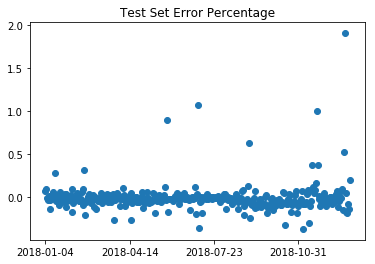

In [62]:
# Christmas is the most poorly perdicted
from matplotlib.pyplot import scatter, title
import matplotlib as plt

fig, ax = plt.pyplot.subplots()
scatter(test_data['date'], errors_percent)
ax.set_xticks(ax.get_xticks()[::100])
title("Test Set Error Percentage")

# Add Holiday Flags and Weather Data

In [21]:
# downloaded from https://gist.github.com/shivaas/4758439
holidays = pd.read_csv("bank_holidays.csv", header=None)
holidays.head()

,0,1,2
0,1,2012-01-02,New Year Day
1,2,2012-01-16,Martin Luther King Jr. Day
2,3,2012-02-20,Presidents Day (Washingtons Birthday)
3,4,2012-05-28,Memorial Day
4,5,2012-07-04,Independence Day


In [22]:
holidays[2].unique()

array(['New Year Day', 'Martin Luther King Jr. Day',
       'Presidents Day (Washingtons Birthday)', 'Memorial Day',
       'Independence Day', 'Labor Day', 'Columbus Day', 'Veterans Day',
       'Thanksgiving Day', 'Christmas Day'], dtype=object)

In [23]:
def is_holiday(row):
    # include Christmas Eve and Ney Year's Eve
    if (row['date'] in list(holidays[1])) or (row['day']==24 and row['month']==12) or (row['day']==31 and row['month']==12):
        return 1.0
    else:
        return 0.0
    
rides_sorted['Holiday'] = rides_sorted.apply(is_holiday, axis=1)

In [24]:
rides_holidays = rides_sorted
for holiday in list(holidays[2].unique()):
    holiday_df = holidays[holidays[2]==holiday]
    def is_holiday(row):
        if (row['date'] in list(holiday_df[1])):
            return 1.0
        else:
            return 0.0
    rides_holidays[holiday] = rides_holidays.apply(is_holiday, axis=1)


In [25]:
def is_xmas_eve(row):
    # include Christmas Eve and Ney Year's Eve
    if row['day']==24 and row['month']==12:
        return 1.0
    else:
        return 0.0
    
rides_holidays['Christmas Eve'] = rides_holidays.apply(is_xmas_eve, axis=1)

In [26]:
def is_ny_eve(row):
    # include Christmas Eve and Ney Year's Eve
    if row['day']==31 and row['month']==12:
        return 1.0
    else:
        return 0.0
    
rides_holidays['New Years Eve'] = rides_holidays.apply(is_ny_eve, axis=1)

In [27]:
rides_holidays[rides_holidays.month==12].sort_values('date', ascending=False).iloc[0:10, :]

,date,year,month,day,month_year,dow,year.1,weekend_flag,yesterday,year_ago,...,Presidents Day (Washingtons Birthday),Memorial Day,Independence Day,Labor Day,Columbus Day,Veterans Day,Thanksgiving Day,Christmas Day,Christmas Eve,New Years Eve
1534,2018-12-31,2018,12,31,122018,1,2018,False,2018-12-30,2017-12-31,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1635,2018-12-30,2018,12,30,122018,0,2018,True,2018-12-29,2017-12-30,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
903,2018-12-29,2018,12,29,122018,6,2018,True,2018-12-28,2017-12-29,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
198,2018-12-28,2018,12,28,122018,5,2018,False,2018-12-27,2017-12-28,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
834,2018-12-27,2018,12,27,122018,4,2018,False,2018-12-26,2017-12-27,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
712,2018-12-26,2018,12,26,122018,3,2018,False,2018-12-25,2017-12-26,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87,2018-12-25,2018,12,25,122018,2,2018,False,2018-12-24,2017-12-25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
827,2018-12-24,2018,12,24,122018,1,2018,False,2018-12-23,2017-12-24,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
85,2018-12-23,2018,12,23,122018,0,2018,True,2018-12-22,2017-12-23,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
254,2018-12-22,2018,12,22,122018,6,2018,True,2018-12-21,2017-12-22,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Weather Data is from https://www.ncdc.noaa.gov/cdo-web/datasets#GHCND.  It must be requested for download. 

In [33]:
weather = pd.read_csv("1709387.csv")

In [34]:
weather.columns

Index(['STATION', 'NAME', 'DATE', 'PRCP', 'SNOW', 'SNWD', 'TAVG', 'TMAX',
       'TMIN'],
      dtype='object')

In [35]:
weather.columns = ['station', 'name', 'date', 'PRCP', 'SNOW', 'SNWD', 'TAVG', 'TMAX', 'TMIN'] 

In [36]:
weather.head()

,station,name,date,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN
0,USW00023272,"SAN FRANCISCO DOWNTOWN, CA US",2013-01-01,0.00,NaN,NaN,NaN,53,43
1,USW00023272,"SAN FRANCISCO DOWNTOWN, CA US",2013-01-02,0.00,0.0,0.0,NaN,56,42
2,USW00023272,"SAN FRANCISCO DOWNTOWN, CA US",2013-01-03,0.00,0.0,0.0,NaN,54,41
3,USW00023272,"SAN FRANCISCO DOWNTOWN, CA US",2013-01-04,0.00,0.0,0.0,NaN,57,45
4,USW00023272,"SAN FRANCISCO DOWNTOWN, CA US",2013-01-05,0.25,0.0,0.0,NaN,53,45


In [41]:
rides_weather = pd.merge(rides_holidays, weather[['date', 'PRCP', 'TMAX', 'TMIN']], on='date', how='left')

In [42]:
rides_weather.head()

,date,year,month,day,month_year,dow,year.1,weekend_flag,yesterday,year_ago,...,Labor Day,Columbus Day,Veterans Day,Thanksgiving Day,Christmas Day,Christmas Eve,New Years Eve,PRCP,TMAX,TMIN
0,2014-01-21,2014,1,21,12014,2,2014,False,2014-01-20,2013-01-21,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,66.0,49.0
1,2014-01-22,2014,1,22,12014,3,2014,False,2014-01-21,2013-01-22,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69.0,48.0
2,2014-01-23,2014,1,23,12014,4,2014,False,2014-01-22,2013-01-23,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68.0,48.0
3,2014-01-24,2014,1,24,12014,5,2014,False,2014-01-23,2013-01-24,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,65.0,49.0
4,2014-01-25,2014,1,25,12014,6,2014,True,2014-01-24,2013-01-25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71.0,50.0


In [43]:
rides_weather.columns

Index(['date', 'year', 'month', 'day', 'month_year', 'dow', 'year.1',
       'weekend_flag', 'yesterday', 'year_ago', 'prior_month_year', 'season',
       'swipes', 'y_date', 'yesterday_swipes', 'ly_date', 'year_ago_swipes',
       'mwd_month_year', 'weekday_avg_month_prior', 'mwe_month_year',
       'weekend_avg_month_prior', 'Holiday', 'New Year Day',
       'Martin Luther King Jr. Day', 'Presidents Day (Washingtons Birthday)',
       'Memorial Day', 'Independence Day', 'Labor Day', 'Columbus Day',
       'Veterans Day', 'Thanksgiving Day', 'Christmas Day', 'Christmas Eve',
       'New Years Eve', 'PRCP', 'TMAX', 'TMIN'],
      dtype='object')

In [48]:
rides_weather[rides_weather.PRCP.isna()]  # missing weather data for one date

,date,year,month,day,month_year,dow,year.1,weekend_flag,yesterday,year_ago,...,Labor Day,Columbus Day,Veterans Day,Thanksgiving Day,Christmas Day,Christmas Eve,New Years Eve,PRCP,TMAX,TMIN
1499,2018-02-28,2018,2,28,22018,3,2018,False,2018-02-27,2017-02-28,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN


In [54]:
rides_weather = rides_weather.fillna(0.0) # fill date with 0.0 

In [55]:
[i for i in rides_weather.date.unique() if i == 0.0]

[]

In [68]:
split = int(.8*len(rides_holidays))

train_data = rides_weather.iloc[0:split, :]
test_data = rides_weather.iloc[split:, :]

features = ['month', 'day', 'dow', 'year', 'season', 'weekend_flag', 
            'yesterday_swipes', 'year_ago_swipes', 'weekday_avg_month_prior', 
            'weekend_avg_month_prior', 'Holiday', 'New Year Day',
           'Martin Luther King Jr. Day', 'Presidents Day (Washingtons Birthday)',
           'Memorial Day', 'Independence Day', 'Labor Day', 'Columbus Day',
           'Veterans Day', 'Thanksgiving Day', 'Christmas Day', 'Christmas Eve',
           'New Years Eve', 'PRCP', 'TMAX', 'TMIN']

X = rides_weather[features]
y = rides_weather['swipes']

X_train = train_data[features]
X_test = test_data[features] 
y_train = train_data['swipes']
y_test = test_data['swipes']


rides_rf = RandomForestRegressor().fit(X_train, y_train)

rides_rf.score(X_test, y_test) # coefficient of determination R^2 of the prediction.
# depending on the random split this will vary

0.958910455174258

In [69]:
# Use the forest's predict method on the test data
predictions = rides_rf.predict(X_test)
# Calculate the absolute errors
abs_errors = abs(predictions - y_test)
sq_errors = (predictions - y_test)**2
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(abs_errors), 4))
print('RMSE :', round(np.sqrt(np.mean(sq_errors)), 4))

Mean Absolute Error: 32474.7536
RMSE : 44816.6324


In [70]:
from sklearn.metrics import median_absolute_error
median_absolute_error(y_test, predictions)

23093.649999999965

In [71]:
from sklearn.model_selection import cross_val_score

scores_dtr = cross_val_score(rides_rf, X, y, cv=10,scoring='explained_variance') # 10-fold cross validation
print('scores for k=10 fold validation:',scores_dtr)
print("Est. explained variance: %0.2f (+/- %0.2f)" % (scores_dtr.mean(), scores_dtr.std() * 2))

scores for k=10 fold validation: [0.9700052  0.93221885 0.99088585 0.97230816 0.98289964 0.97694264
 0.98178547 0.9821534  0.97723536 0.96249341]
Est. explained variance: 0.97 (+/- 0.03)


In [72]:
from sklearn.metrics import explained_variance_score
# Best possible score is 1.0, lower values are worse.
explained_variance_score(y_test, predictions)

0.9649660966303746

In [73]:
feature_importances_all = pd.DataFrame(rides_rf.feature_importances_,
                                     index = X_train.columns, 
                                     columns=['importance']).sort_values('importance', ascending=False)
feature_importances_all

,importance
weekend_flag,6.298778e-01
yesterday_swipes,2.576482e-01
Holiday,4.891765e-02
dow,1.415085e-02
year,1.017371e-02
year_ago_swipes,5.843003e-03
Thanksgiving Day,5.226175e-03
month,4.653016e-03
Columbus Day,3.714696e-03
weekday_avg_month_prior,3.693386e-03


In [74]:
abs_errors_percent = abs((predictions - y_test)/y_test)
print("This model's predictions is on average about ", round(np.mean(abs_errors_percent), 4), "off of the actual ridership for that day")


This model's predictions is on average about  0.0497 off of the actual ridership for that day


In [75]:
errors_percent = (predictions - y_test)/y_test
test_errors = X_test
test_errors['actual'] = y_test
test_errors['predicted'] = predictions
test_errors['errors_percents'] = errors_percent
test_errors.sort_values('errors_percents')[['month', 'day', 'year', 'errors_percents', 'actual', 'predicted']]


,month,day,year,errors_percents,actual,predicted
1756,11,12,2018,-0.380660,506591,313752.3
1757,11,13,2018,-0.238463,831737,633398.4
1798,12,24,2018,-0.187855,299764,243451.8
1802,12,28,2018,-0.162119,523107,438301.3
1768,11,24,2018,-0.153702,303763,257073.9
1687,9,4,2018,-0.149401,740397,629781.1
1615,6,24,2018,-0.147074,391022,333512.7
1721,10,8,2018,-0.144911,664139,567897.7
1679,8,27,2018,-0.139221,714778,615265.7
1491,2,20,2018,-0.138480,665281,573153.1


Text(0.5, 1.0, 'Test Set Error Percentage')

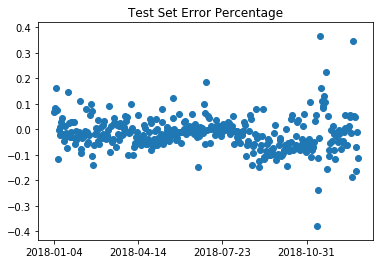

In [76]:
from matplotlib.pyplot import scatter, title
import matplotlib as plt

fig, ax = plt.pyplot.subplots()
scatter(test_data['date'], errors_percent)
ax.set_xticks(ax.get_xticks()[::100])
title("Test Set Error Percentage")

A model including holidays and weather better predicts clipper swipes in terms of it's $R^2$, MAE, RMSE, explained variance, and the average percent its predictions are off per day in the test set.  Once there is more recent data available models like this could predict future clipper swipes.